In [1]:
# Parameters
distancia = 5000


In [2]:
# Parameters
distancia = 5000


In [3]:
%pip install scikit-learn papermill nbconvert seaborn openmeteo_requests requests_cache retry_requests retry_requests pymysql -U pandas numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import pandas as pd

# 🚫 Sem banco de dados — vamos ler direto do CSV salvo anteriormente
input_file = '../novosDadosTeste.csv'   # arquivo gerado no seu script final.py

# Lendo os dados do CSV
df = pd.read_csv(input_file)

# Salvando no novo arquivo de saída
output_file = 'dados_treinamento.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"✅ Dados exportados com sucesso para o arquivo: {output_file}")

✅ Dados exportados com sucesso para o arquivo: dados_treinamento.csv


In [6]:
df = pd.read_csv('dados_treinamento.csv')
print(df.head())

   total_calorie  heart_rate_sample_count  \
0      631.01870                      NaN   
1      455.57983                      NaN   
2      150.78531                      NaN   
3      716.46234                      NaN   
4      761.18896                      NaN   

   com.samsung.health.exercise.duration  \
0                               2607095   
1                               2840138   
2                               1825625   
3                               3357867   
4                               3103471   

  com.samsung.health.exercise.start_time  \
0                2018-01-18 06:16:12.414   
1                2018-01-20 06:13:41.096   
2                2018-01-21 07:16:19.217   
3                2018-01-23 07:27:49.979   
4                2018-01-25 05:35:34.908   

   com.samsung.health.exercise.mean_heart_rate  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3    

In [7]:
df_to_prepare = df[['com.samsung.health.exercise.distance',
                    'com.samsung.health.exercise.mean_speed',
                    'com.samsung.health.exercise.duration', 'com.samsung.health.exercise.mean_heart_rate',
                    'sleep_duration',
                    'temperature_x', 'humidity_x', 'sleep_score', 'mental_recovery','volume_7d'
                    #'temperature_2m', 'relative_humidity_2m', 'sleep_score', 'mental_recovery'
                    ]]

print(df_to_prepare.head())

   com.samsung.health.exercise.distance  \
0                                6800.0   
1                                6070.0   
2                                2720.0   
3                                7710.0   
4                                7490.0   

   com.samsung.health.exercise.mean_speed  \
0                                2.608362   
1                                2.137324   
2                                1.491228   
3                                2.299433   
4                                2.413793   

   com.samsung.health.exercise.duration  \
0                               2607095   
1                               2840138   
2                               1825625   
3                               3357867   
4                               3103471   

   com.samsung.health.exercise.mean_heart_rate  sleep_duration  temperature_x  \
0                                          NaN             NaN           25.5   
1                                          NaN   

In [8]:
'''df_to_prepare = df_to_prepare.replace({r'\.': ''}, regex=True)
df_to_prepare = df_to_prepare.astype(float)

print(df_to_prepare.dtypes)

non_numeric_columns = df_to_prepare.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", non_numeric_columns)'''

import re
import pandas as pd
import numpy as np

# Função para detectar colunas que não são numéricas
def detectar_colunas_problematicas(df):
    problem = []
    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            problem.append(col)
    return problem

colunas_problematicas = detectar_colunas_problematicas(df_to_prepare)
print("⚠️ Colunas que precisam de limpeza:", colunas_problematicas)

def limpar_valor(v):
    if isinstance(v, str):
        # Extrai o primeiro número (inteiro ou decimal, incluindo negativos)
        numeros = re.findall(r"[-+]?\d*\.\d+|\d+", v)
        if numeros:
            return float(numeros[0])
        else:
            return None
    return v

# Aplica a função somente nas colunas problemáticas
'''colunas_com_texto = [
    'com.samsung.health.exercise.distance',
    'com.samsung.health.exercise.mean_speed',
    #'temperature_2m',
    #'relative_humidity_2m'
]'''

df_to_prepare[colunas_problematicas] = df_to_prepare[colunas_problematicas].applymap(limpar_valor)

# Confere se agora virou float
print(df_to_prepare.dtypes)
# Converte durações no formato "0 days 00:00:00.000..." para segundos
for col in df_to_prepare.columns:
    if df_to_prepare[col].astype(str).str.contains('days').any():
        df_to_prepare[col] = pd.to_timedelta(df_to_prepare[col], errors='coerce').dt.total_seconds()

df_to_prepare = df_to_prepare.replace({r'\.': ''}, regex=True)
df_to_prepare = df_to_prepare.astype(float)

print(df_to_prepare.dtypes)

non_numeric_columns = df_to_prepare.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", non_numeric_columns)


⚠️ Colunas que precisam de limpeza: []
com.samsung.health.exercise.distance           float64
com.samsung.health.exercise.mean_speed         float64
com.samsung.health.exercise.duration             int64
com.samsung.health.exercise.mean_heart_rate    float64
sleep_duration                                 float64
temperature_x                                  float64
humidity_x                                     float64
sleep_score                                    float64
mental_recovery                                float64
volume_7d                                      float64
dtype: object
com.samsung.health.exercise.distance           float64
com.samsung.health.exercise.mean_speed         float64
com.samsung.health.exercise.duration           float64
com.samsung.health.exercise.mean_heart_rate    float64
sleep_duration                                 float64
temperature_x                                  float64
humidity_x                                     float64
sleep_score 

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\10142578\AppData\Local\Temp\ipykernel_7572\1149221216.py:1: SyntaxWarning: invalid escape sequence '\.'
  '''df_to_prepare = df_to_prepare.replace({r'\.': ''}, regex=True)
C:\Users\10142578\AppData\Local\Temp\ipykernel_7572\1149221216.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_to_prepare[colunas_problematicas] = df_to_prepare[colunas_problematicas].applymap(limpar_valor)


In [9]:
df_to_prepare.fillna(df_to_prepare.mean(), inplace=True)  # Substituir NaN pela média

#print(df_to_prepare.head())


In [10]:
# Definir o índice para dividir os dados (80% para treino)
train_size = int(len(df) * 0.8)

train = df_to_prepare.iloc[:train_size]
test = df_to_prepare.iloc[train_size:]

X_train = train.drop(columns=['com.samsung.health.exercise.duration'])
y_train = train['com.samsung.health.exercise.duration']
X_test = test.drop(columns=['com.samsung.health.exercise.duration'])
y_test = test['com.samsung.health.exercise.duration']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_test.to_csv("dados_de_teste.csv", index=False)
X_train.to_csv("df_treinamento.csv", index=False)


(136, 9)

 (35, 9) (136,) (35,)


In [11]:

for col in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Coluna não numérica encontrada: {col}")



In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# --- Criar pasta de saída ---
output_dir = "resultados_modelos"
os.makedirs(output_dir, exist_ok=True)

# --- Definir modelos ---
models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

# --- Separar features e target ---
X = df_to_prepare.drop(columns=['com.samsung.health.exercise.duration'])
y = df_to_prepare['com.samsung.health.exercise.duration']

# --- Configurar K-Fold ---
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Loop pelos modelos ---
for name, model in models.items():
    print(f"Treinando {name} com K-Fold...")

    # Predições via validação cruzada
    y_pred = cross_val_predict(model, X, y, cv=kfold)

    # Métricas
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}\n")

    # Salvar predições
    output_file = os.path.join(output_dir, f"{name}_predicoes.csv")
    result_df = pd.DataFrame({
        "Valor Real": y,
        "Predição": y_pred,
        "Erro Absoluto": abs(y - y_pred)
    })
    result_df.to_csv(output_file, index=False)
    print(f"Resultados de {name} salvos em: {output_file}\n")

# --- Resultados finais ---
print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")



Treinando Gradient Boosting com K-Fold...


Gradient Boosting - MAE: 122092.8107, RMSE: 231759.4534, R²: 0.9607

Resultados de Gradient Boosting salvos em: resultados_modelos\Gradient Boosting_predicoes.csv

Treinando SVR com K-Fold...
SVR - MAE: 841072.3657, RMSE: 1174842.9832, R²: -0.0097

Resultados de SVR salvos em: resultados_modelos\SVR_predicoes.csv

Treinando KNN com K-Fold...
KNN - MAE: 823553.6129, RMSE: 1200834.5312, R²: -0.0548

Resultados de KNN salvos em: resultados_modelos\KNN_predicoes.csv

Treinando Decision Tree com K-Fold...
Decision Tree - MAE: 189847.7427, RMSE: 305091.7978, R²: 0.9319

Resultados de Decision Tree salvos em: resultados_modelos\Decision Tree_predicoes.csv

Treinando Random Forest com K-Fold...


Random Forest - MAE: 157769.3708, RMSE: 260391.3809, R²: 0.9504

Resultados de Random Forest salvos em: resultados_modelos\Random Forest_predicoes.csv

Treinando Linear Regression com K-Fold...
Linear Regression - MAE: 142031.5024, RMSE: 194949.2810, R²: 0.9722

Resultados de Linear Regression salvos em: resultados_modelos\Linear Regression_predicoes.csv

Resultados Finais:
Gradient Boosting: {'MAE': 122092.8106779467, 'RMSE': np.float64(231759.45342578093), 'R²': 0.9607092951774024}
SVR: {'MAE': 841072.365722023, 'RMSE': np.float64(1174842.9831941016), 'R²': -0.009658622170386044}
KNN: {'MAE': 823553.6128654971, 'RMSE': np.float64(1200834.5312199448), 'R²': -0.05482700451675693}
Decision Tree: {'MAE': 189847.74269005848, 'RMSE': np.float64(305091.79778802994), 'R²': 0.9319111549286627}
Random Forest: {'MAE': 157769.3707602339, 'RMSE': np.float64(260391.38087749318), 'R²': 0.950401549036112}
Linear Regression: {'MAE': 142031.5024398397, 'RMSE': np.float64(194949.28099730404), 'R²': 0.9

In [13]:


output_dir = "resultados_modelos"
os.makedirs(output_dir, exist_ok=True)

models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    output_file = os.path.join(output_dir, f"{name}_predicoes.csv")
    result_df = pd.DataFrame({
        "Valor Real": y_test,
        "Predição": y_pred,
        "Erro Absoluto": abs(y_test - y_pred)
    })
    result_df.to_csv(output_file, index=False)
    print(f"Resultados de {name} salvos em: {output_file}")

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")


Treinando Gradient Boosting...
Gradient Boosting - MAE: 273169.190257228, RMSE: 499066.7448730887, R²: 0.8957958477750119

Resultados de Gradient Boosting salvos em: resultados_modelos\Gradient Boosting_predicoes.csv
Treinando SVR...
SVR - MAE: 1215482.481159831, RMSE: 1668434.9943272464, R²: -0.16462562540244452

Resultados de SVR salvos em: resultados_modelos\SVR_predicoes.csv
Treinando KNN...
KNN - MAE: 1092584.2457142856, RMSE: 1677049.5720177076, R²: -0.17668322294210892

Resultados de KNN salvos em: resultados_modelos\KNN_predicoes.csv
Treinando Decision Tree...
Decision Tree - MAE: 336348.85714285716, RMSE: 523696.51571300614, R²: 0.885256754426716

Resultados de Decision Tree salvos em: resultados_modelos\Decision Tree_predicoes.csv
Treinando Random Forest...


Random Forest - MAE: 369732.99285714293, RMSE: 576275.1956096585, R²: 0.8610598975670922

Resultados de Random Forest salvos em: resultados_modelos\Random Forest_predicoes.csv
Treinando Linear Regression...
Linear Regression - MAE: 157786.88177764154, RMSE: 219842.8728290015, R²: 0.9797794696439075

Resultados de Linear Regression salvos em: resultados_modelos\Linear Regression_predicoes.csv
Resultados Finais:
Gradient Boosting: {'MAE': 273169.190257228, 'RMSE': np.float64(499066.7448730887), 'R²': 0.8957958477750119}
SVR: {'MAE': 1215482.481159831, 'RMSE': np.float64(1668434.9943272464), 'R²': -0.16462562540244452}
KNN: {'MAE': 1092584.2457142856, 'RMSE': np.float64(1677049.5720177076), 'R²': -0.17668322294210892}
Decision Tree: {'MAE': 336348.85714285716, 'RMSE': np.float64(523696.51571300614), 'R²': 0.885256754426716}
Random Forest: {'MAE': 369732.99285714293, 'RMSE': np.float64(576275.1956096585), 'R²': 0.8610598975670922}
Linear Regression: {'MAE': 157786.88177764154, 'RMSE': np.f

In [14]:

models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}

feature_importances = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

if feature_importances:
    print("\nImportância das Features:")
    for model_name, importances in feature_importances.items():
        feature_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(f"\n{model_name} Feature Importances:")
        print(feature_df)


Treinando Gradient Boosting...
Gradient Boosting - MAE: 273169.190257228, RMSE: 499066.7448730887, R²: 0.8957958477750119

Treinando SVR...
SVR - MAE: 1215482.481159831, RMSE: 1668434.9943272464, R²: -0.16462562540244452

Treinando KNN...
KNN - MAE: 1092584.2457142856, RMSE: 1677049.5720177076, R²: -0.17668322294210892

Treinando Decision Tree...
Decision Tree - MAE: 336348.85714285716, RMSE: 523696.51571300614, R²: 0.885256754426716

Treinando Random Forest...


Random Forest - MAE: 369732.99285714293, RMSE: 576275.1956096585, R²: 0.8610598975670922

Treinando Linear Regression...
Linear Regression - MAE: 157786.88177764154, RMSE: 219842.8728290015, R²: 0.9797794696439075

Resultados Finais:
Gradient Boosting: {'MAE': 273169.190257228, 'RMSE': np.float64(499066.7448730887), 'R²': 0.8957958477750119}
SVR: {'MAE': 1215482.481159831, 'RMSE': np.float64(1668434.9943272464), 'R²': -0.16462562540244452}
KNN: {'MAE': 1092584.2457142856, 'RMSE': np.float64(1677049.5720177076), 'R²': -0.17668322294210892}
Decision Tree: {'MAE': 336348.85714285716, 'RMSE': np.float64(523696.51571300614), 'R²': 0.885256754426716}
Random Forest: {'MAE': 369732.99285714293, 'RMSE': np.float64(576275.1956096585), 'R²': 0.8610598975670922}
Linear Regression: {'MAE': 157786.88177764154, 'RMSE': np.float64(219842.8728290015), 'R²': 0.9797794696439075}

Importância das Features:

Gradient Boosting Feature Importances:
                                       Feature  Importance
0

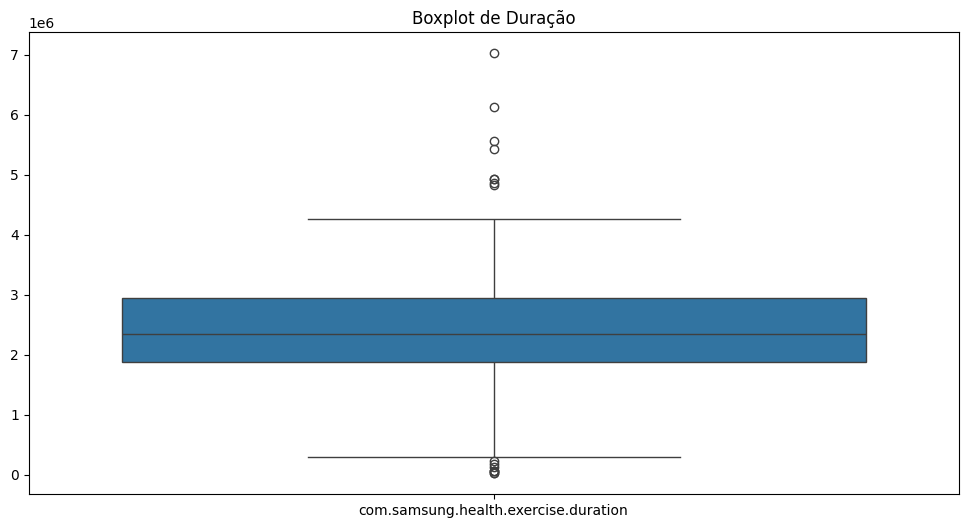

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['com.samsung.health.exercise.duration']])
plt.title("Boxplot de Duração")
plt.show()

In [16]:
Q1 = df['com.samsung.health.exercise.duration'].quantile(0.25)
Q3 = df['com.samsung.health.exercise.duration'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}")


Limite Inferior: 283380.25, Limite Superior: 4530966.25


In [17]:
df_sem_outliers = df_to_prepare[
    (df_to_prepare['com.samsung.health.exercise.duration'] >= limite_inferior) &
    (df_to_prepare['com.samsung.health.exercise.duration'] <= limite_superior)
]

outliers = df_to_prepare[
    (df_to_prepare['com.samsung.health.exercise.duration'] < limite_inferior) |
    (df_to_prepare['com.samsung.health.exercise.duration'] > limite_superior)
]

outliers.to_csv('outliers_removed.csv', index=False)

In [18]:

train_size = int(len(df) * 0.8)

train = df_sem_outliers.iloc[:train_size]
test = df_sem_outliers.iloc[train_size:]

X_train = train.drop(columns=['com.samsung.health.exercise.duration'])
y_train = train['com.samsung.health.exercise.duration']
X_test = test.drop(columns=['com.samsung.health.exercise.duration'])
y_test = test['com.samsung.health.exercise.duration']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(136, 9) (19, 9) (136,) (19,)


In [19]:

for col in X_train.columns:
    if not pd.api.types.is_numeric_dtype(X_train[col]):
        print(f"Coluna não numérica encontrada: {col}")



In [20]:
output_dir = "resultados_modelos_sem_outliers"
os.makedirs(output_dir, exist_ok=True)

for name, model in models.items():
    print(f"Treinando {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    output_file = os.path.join(output_dir, f"{name}_predicoes.csv")
    result_df = pd.DataFrame({
        "Valor Real": y_test,
        "Predição": y_pred,
        "Erro Absoluto": abs(y_test - y_pred)
    })
    result_df.to_csv(output_file, index=False)
    print(f"Resultados de {name} salvos em: {output_file}")

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

Treinando Gradient Boosting...


Gradient Boosting - MAE: 141921.80074244962, RMSE: 183318.07181477692, R²: 0.9455606532972638

Resultados de Gradient Boosting salvos em: resultados_modelos_sem_outliers\Gradient Boosting_predicoes.csv
Treinando SVR...
SVR - MAE: 653116.9039859432, RMSE: 848126.3019334208, R²: -0.1652615250424334

Resultados de SVR salvos em: resultados_modelos_sem_outliers\SVR_predicoes.csv
Treinando KNN...
KNN - MAE: 513422.39999999997, RMSE: 720740.7108469101, R²: 0.15848773303848207

Resultados de KNN salvos em: resultados_modelos_sem_outliers\KNN_predicoes.csv
Treinando Decision Tree...
Decision Tree - MAE: 153809.36842105264, RMSE: 197513.219991926, R²: 0.9368032590839755

Resultados de Decision Tree salvos em: resultados_modelos_sem_outliers\Decision Tree_predicoes.csv
Treinando Random Forest...


Random Forest - MAE: 173865.46105263152, RMSE: 231619.2424652463, R²: 0.9130936285586656

Resultados de Random Forest salvos em: resultados_modelos_sem_outliers\Random Forest_predicoes.csv
Treinando Linear Regression...
Linear Regression - MAE: 107749.87967690984, RMSE: 148024.29637364417, R²: 0.9645049040581601

Resultados de Linear Regression salvos em: resultados_modelos_sem_outliers\Linear Regression_predicoes.csv
Resultados Finais:
Gradient Boosting: {'MAE': 141921.80074244962, 'RMSE': np.float64(183318.07181477692), 'R²': 0.9455606532972638}
SVR: {'MAE': 653116.9039859432, 'RMSE': np.float64(848126.3019334208), 'R²': -0.1652615250424334}
KNN: {'MAE': 513422.39999999997, 'RMSE': np.float64(720740.7108469101), 'R²': 0.15848773303848207}
Decision Tree: {'MAE': 153809.36842105264, 'RMSE': np.float64(197513.219991926), 'R²': 0.9368032590839755}
Random Forest: {'MAE': 173865.46105263152, 'RMSE': np.float64(231619.2424652463), 'R²': 0.9130936285586656}
Linear Regression: {'MAE': 107749.

# Outro teste

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Padronizar os dados para modelos sensíveis a escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de modelos com hiperparâmetros melhores
models = {
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "SVR": SVR(kernel='rbf', C=10, gamma=0.1),
    "KNN": KNeighborsRegressor(n_neighbors=5, weights='distance'),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
    "Linear Regression": LinearRegression()
}

results = {}
feature_importances = {}

for name, model in models.items():
    print(f"Treinando {name}...")

    if name in ["SVR", "KNN", "Gradient Boosting"]:
        X_train_used, X_test_used = X_train_scaled, X_test_scaled
    else:
        X_train_used, X_test_used = X_train, X_test

    model.fit(X_train_used, y_train)

    y_pred = model.predict(X_test_used)

    # Corrigir previsões irreais (se o erro for maior que 30% da média dos tempos reais é feito o ajuste)
    media_real = y_test.mean()
    limite_min = media_real * 0.7  # 70% da média
    limite_max = media_real * 1.3  # 130% da média
    y_pred = np.clip(y_pred, limite_min, limite_max)

    mae = mean_absolute_error(y_test, y_pred)
    #rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
    print(f"{name} - MAE: {mae}, RMSE: {rmse}, R²: {r2}\n")

    if hasattr(model, "feature_importances_"):
        feature_importances[name] = model.feature_importances_

print("Resultados Finais:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")

if feature_importances:
    print("\nImportância das Features:")
    for model_name, importances in feature_importances.items():
        feature_df = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(f"\n{model_name} Feature Importances:")
        print(feature_df)


Treinando Gradient Boosting...


Gradient Boosting - MAE: 246306.3454432049, RMSE: 326198.8630872504, R²: 0.8276277979509561

Treinando SVR...
SVR - MAE: 653107.5594985918, RMSE: 848106.3043449611, R²: -0.1652065753358769

Treinando KNN...
KNN - MAE: 388937.4529495447, RMSE: 450315.29446316673, R²: 0.6714997240130289

Treinando Decision Tree...
Decision Tree - MAE: 253604.49628237254, RMSE: 324534.1681940979, R²: 0.8293826473165898

Treinando Random Forest...


Random Forest - MAE: 259175.8105263157, RMSE: 341055.4097444139, R²: 0.8115690538207236

Treinando Linear Regression...
Linear Regression - MAE: 220383.69287089657, RMSE: 307878.84674007195, R²: 0.8464456776122364

Resultados Finais:
Gradient Boosting: {'MAE': 246306.3454432049, 'RMSE': np.float64(326198.8630872504), 'R²': 0.8276277979509561}
SVR: {'MAE': 653107.5594985918, 'RMSE': np.float64(848106.3043449611), 'R²': -0.1652065753358769}
KNN: {'MAE': 388937.4529495447, 'RMSE': np.float64(450315.29446316673), 'R²': 0.6714997240130289}
Decision Tree: {'MAE': 253604.49628237254, 'RMSE': np.float64(324534.1681940979), 'R²': 0.8293826473165898}
Random Forest: {'MAE': 259175.8105263157, 'RMSE': np.float64(341055.4097444139), 'R²': 0.8115690538207236}
Linear Regression: {'MAE': 220383.69287089657, 'RMSE': np.float64(307878.84674007195), 'R²': 0.8464456776122364}

Importância das Features:

Gradient Boosting Feature Importances:
                                       Feature  Importance
0    

In [22]:
df_sem_outliers.loc[:, 'com.samsung.health.exercise.duration'] = df_sem_outliers['com.samsung.health.exercise.duration'].clip(lower=limite_inferior, upper=limite_superior)

print(df_sem_outliers.head(198))

     com.samsung.health.exercise.distance  \
0                                6800.000   
1                                6070.000   
2                                2720.000   
3                                7710.000   
4                                7490.000   
..                                    ...   
166                              8517.041   
167                              8581.399   
168                              8238.515   
169                              5032.352   
170                              5453.060   

     com.samsung.health.exercise.mean_speed  \
0                                  2.608362   
1                                  2.137324   
2                                  1.491228   
3                                  2.299433   
4                                  2.413793   
..                                      ...   
166                                3.094580   
167                                2.847469   
168                                2

In [23]:
import joblib

# Diretório para salvar os modelos
model_filenames = {
    "Gradient Boosting": "gradient_boosting_sem_caloria.pkl",
    "SVR": "svr_sem_caloria.pkl",
    "KNN": "knn_sem_caloria.pkl",
    "Decision Tree": "decision_tree_sem_caloria.pkl",
    "Random Forest": "random_forest_sem_caloria.pkl",
    "Linear Regression": "linear_regression_sem_caloria.pkl"
}

for name, model in models.items():
    filename = model_filenames[name]
    joblib.dump(model, filename)
    print(f"Modelo {name} salvo como {filename}")


Modelo Gradient Boosting salvo como gradient_boosting_sem_caloria.pkl
Modelo SVR salvo como svr_sem_caloria.pkl
Modelo KNN salvo como knn_sem_caloria.pkl
Modelo Decision Tree salvo como decision_tree_sem_caloria.pkl


Modelo Random Forest salvo como random_forest_sem_caloria.pkl
Modelo Linear Regression salvo como linear_regression_sem_caloria.pkl


In [24]:
import joblib
import pandas as pd

model_filenames = {
    "Gradient Boosting": "gradient_boosting_sem_caloria.pkl",
    "SVR": "svr_sem_caloria.pkl",
    "KNN": "knn_sem_caloria.pkl",
    "Decision Tree": "decision_tree_sem_caloria.pkl",
    "Random Forest": "random_forest_sem_caloria.pkl",
    "Linear Regression": "linear_regression_sem_caloria.pkl"
}

# Carrega os modelos
try:
    models = {name: joblib.load(filename) for name, filename in model_filenames.items()}
except FileNotFoundError as e:
    print(f"Erro ao carregar modelos: {e}")
    exit()

# Carrega os dados de teste
try:
    X_test = pd.read_csv("dados_de_teste.csv")  # Ajuste o caminho se necessário
except FileNotFoundError:
    print("Arquivo 'dados_de_teste.csv' não encontrado.")
    exit()

if X_test.empty:
    print("O arquivo 'dados_de_teste.csv' está vazio.")
    exit()

# Extrai a última linha dos dados de teste
ultima_linha = X_test.iloc[-1].to_dict()

# Função para fazer a previsão
def prever_duracao(model, distancia):
    dados = ultima_linha.copy()

    # Converte a distância para o mesmo tipo de dado presente no dataset
    try:
        distancia = type(dados['com.samsung.health.exercise.distance'])(distancia)
    except KeyError:
        print("Coluna 'com.samsung.health.exercise.distance' não encontrada no dataset.")
        return None, None

    dados['com.samsung.health.exercise.distance'] = distancia

    df = pd.DataFrame([dados])

    try:
        duracao_ms = model.predict(df)[0]  # Retorna a duração prevista em milissegundos
    except Exception as e:
        print(f"Erro ao fazer previsão com o modelo: {e}")
        return None, None

    # Converte milissegundos para minutos e segundos
    duracao_segundos = duracao_ms / 1000
    minutos = int(duracao_segundos // 60)
    segundos = int(duracao_segundos % 60)

    return minutos, segundos

'''distancia = input("Digite a distância em metros: ")

try:
    distancia = float(distancia)
except ValueError:
    print("Entrada inválida para distância. Digite um número válido.")
    exit()'''
    
# ============================================
# VARIÁVEL DISTANCIA VEM DO PAPERMILL
# ============================================

try:
    distancia
except NameError:
    raise ValueError("❌ ERRO: o notebook foi executado sem receber o parâmetro 'distancia'.")

distancia = float(distancia)


# Roda todos os modelos e exibir previsões
print("\nResultados das previsões:")
for name, model in models.items():
    minutos, segundos = prever_duracao(model, distancia)
    if minutos is not None and segundos is not None:
        print(f"{name}: {minutos} minutos e {segundos} segundos.")


Resultados das previsões:
Gradient Boosting: 65 minutos e 3 segundos.
SVR: 38 minutos e 37 segundos.
KNN: 34 minutos e 3 segundos.
Decision Tree: 33 minutos e 7 segundos.
Random Forest: 32 minutos e 31 segundos.
Linear Regression: 29 minutos e 16 segundos.


C:\Users\10142578\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\Users\10142578\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\10142578\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


                                             com.samsung.health.exercise.distance  \
com.samsung.health.exercise.distance                                     1.000000   
com.samsung.health.exercise.mean_speed                                   0.441772   
com.samsung.health.exercise.duration                                     0.978455   
com.samsung.health.exercise.mean_heart_rate                              0.329422   
sleep_duration                                                           0.042615   
temperature_x                                                            0.100371   
humidity_x                                                              -0.104303   
sleep_score                                                              0.155196   
mental_recovery                                                          0.328662   
volume_7d                                                                0.197954   

                                             com.samsung.health.

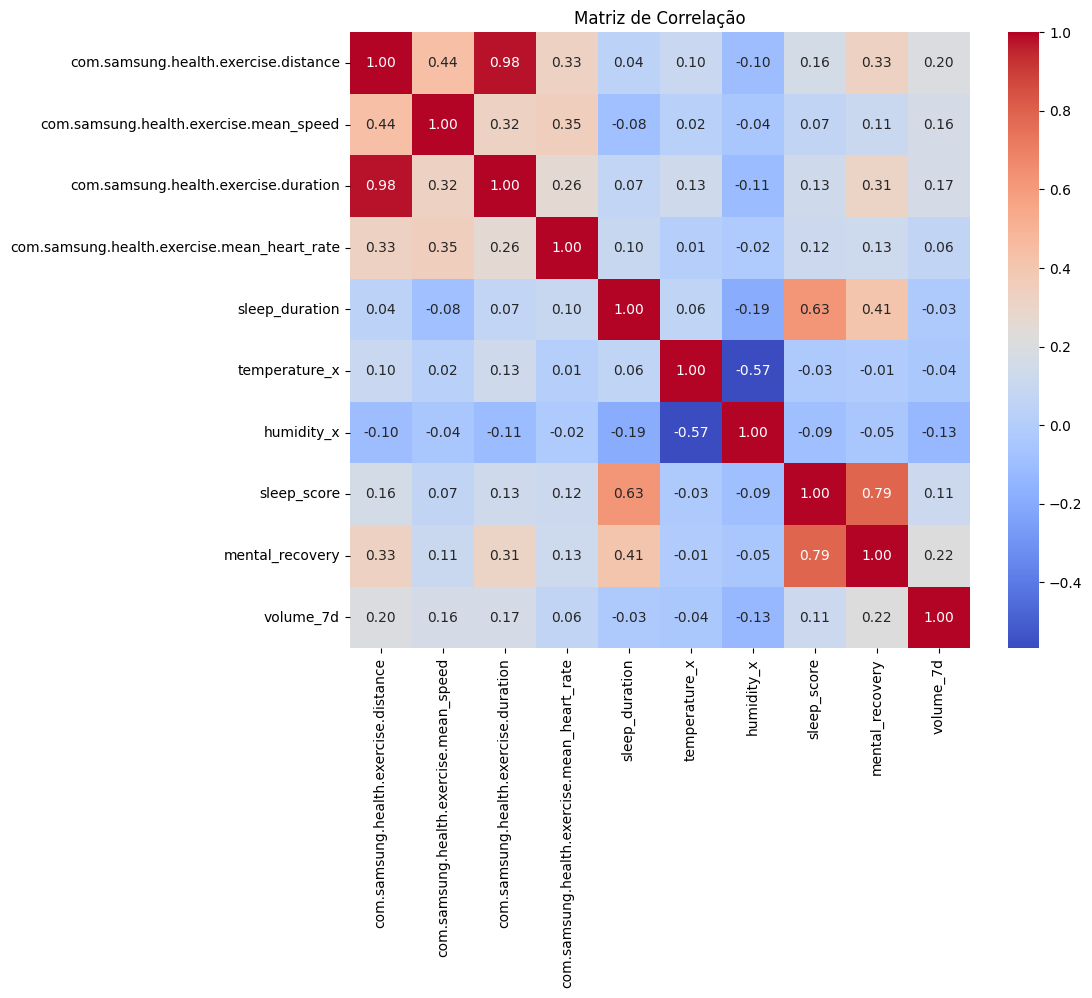

In [25]:
correlation_matrix = df_to_prepare.corr()

# Exibir a matriz de correlação
print(correlation_matrix)

# Plotar como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()